# AdventureWorks Försäljningsanalys
I denna analys undersöker vi AdventureWorks- databasen för att besvara affärsfrågor som exempelvis:
- Produktkategorier och deras försäljning
- Försäljningstrender över tid
- Regional försäljning

Vi använder SQL för att hämta data och Python för visualisering och analys.

In [22]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus

user = "SA"
password = quote_plus("Zemer6969")
server = 'localhost:1433'
database = 'AdventureWorks2025'
driver = quote_plus("ODBC Driver 18 for SQL server")


connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)


try:
    with engine.connect():
        print("Anslutning till SQL Server lyckades")
except Exception as e:
    print("Kunde inte ansluta", e)

Anslutning till SQL Server lyckades


C:\Users\kaisa\AppData\Local\Temp\ipykernel_2344\2621769548.py:23: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect():


In [23]:
def query_df(sql: str):
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn)

## Visualisering 1: Antal produkter per kategori
Hur många produkter finns i varje kategori?

Tabeller som används:
- Production.ProductCategory
- Production.ProductSubcategory
- Production.Product

Plan:
1. JOINa tabellerna 
2. Räkna DISTINCT produkt per kategori
3. Skapa verikalt stapeldiagram
4. Analysera resultatet

In [13]:
query_vis1 = """
SELECT
    pc.Name AS CategoryName,
    COUNT (DISTINCT p.ProductID) AS ProductCount
FROM Production.ProductCategory pc 
INNER JOIN Production.ProductSubcategory psc ON pc.ProductCategoryID = psc.ProductCategoryID
LEFT JOIN Production.Product p ON psc.ProductSubcategoryID = p.ProductSubcategoryID
GROUP BY pc.Name
ORDER BY ProductCount DESC
"""

df_vis1 = query_df(query_vis1)

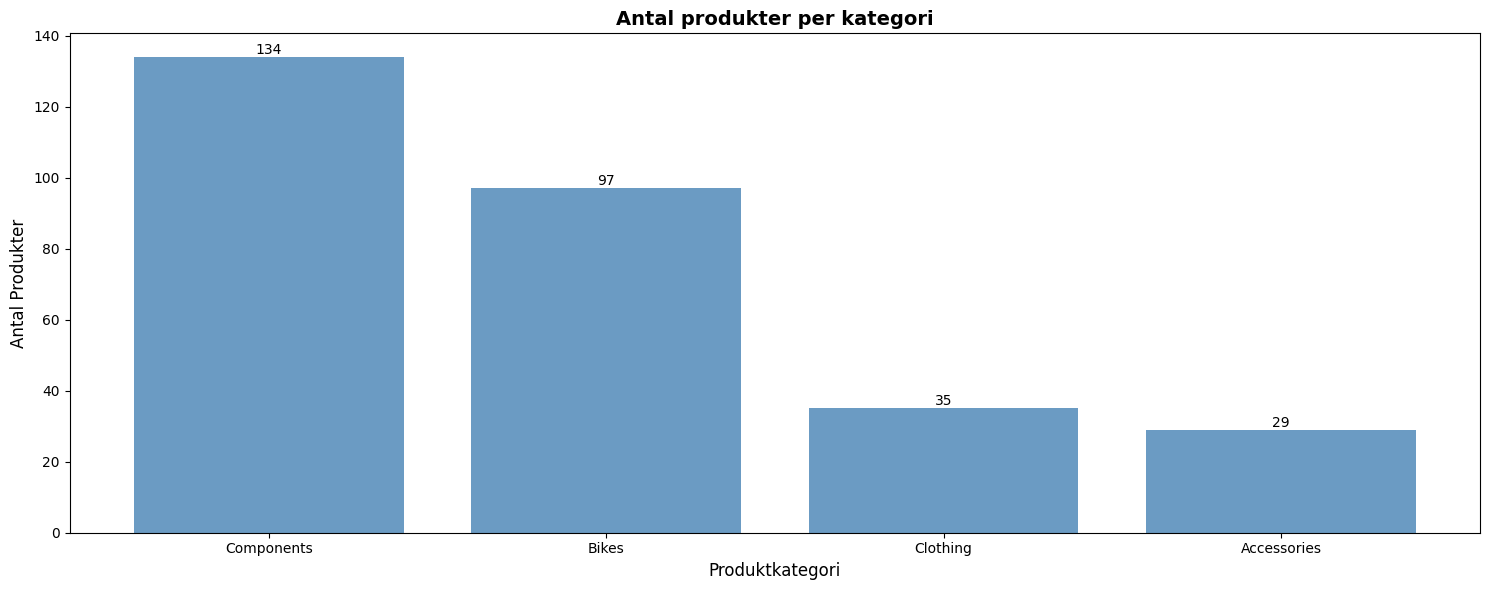

In [25]:
fig, ax = plt.subplots(figsize = (15, 6))

bars = ax.bar(df_vis1['CategoryName'], df_vis1['ProductCount'], color= 'steelblue', alpha= 0.8)

for bar in bars:
    height = bar.get_height()
    ax.text(
    bar.get_x() + bar.get_width()/2,
    height,
    f'{int(height)}',
    ha = 'center',
    va = 'bottom'
    )

ax.set_xlabel('Produktkategori', fontsize = 12)
ax.set_ylabel('Antal Produkter', fontsize = 12)
ax.set_title('Antal produkter per kategori', fontsize= 14, fontweight = 'bold')

plt.tight_layout()
plt.show()

### Insikter - antal produkter per kategori
Components är största kategorin med 134 produkter.
Accessories är minst med 29 produkter.

Detta indikerar på att företaget är stark fokuserad på komponenter och reservdelar. Och att accessories kan vara ett utvecklingsområde.

## Visualisering 2: Försäljning per produktkategori
Vilka produktkategorier genererar mest intäkter?

Tabeller som används:
- Production.ProductCategory,
- Production.ProductSubcategory
- Production.Product
- Sales.SalesOrderDetail

Plan:
1. JOINa tabellerna 
2. Få fram vilken kategori som är störst och minst, med exakta siffror med hjälp av SUM 
3. Skapa horisontellt stapeldiagram (barh)
4. Analysera resultatet

In [21]:
query_vis2 = """
SELECT
    pc.Name AS CategoryName,
    CAST(SUM (sod.LineTotal) AS decimal(18,2)) AS TotalOmsättning
FROM Production.ProductCategory pc 
INNER JOIN Production.ProductSubcategory psc ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p ON psc.ProductSubcategoryID = p.ProductSubcategoryID
INNER JOIN Sales.SalesOrderDetail sod ON p.ProductID = sod.ProductID

GROUP BY pc.Name
ORDER BY TotalOmsättning DESC;
"""

df_vis2 = query_df(query_vis2)

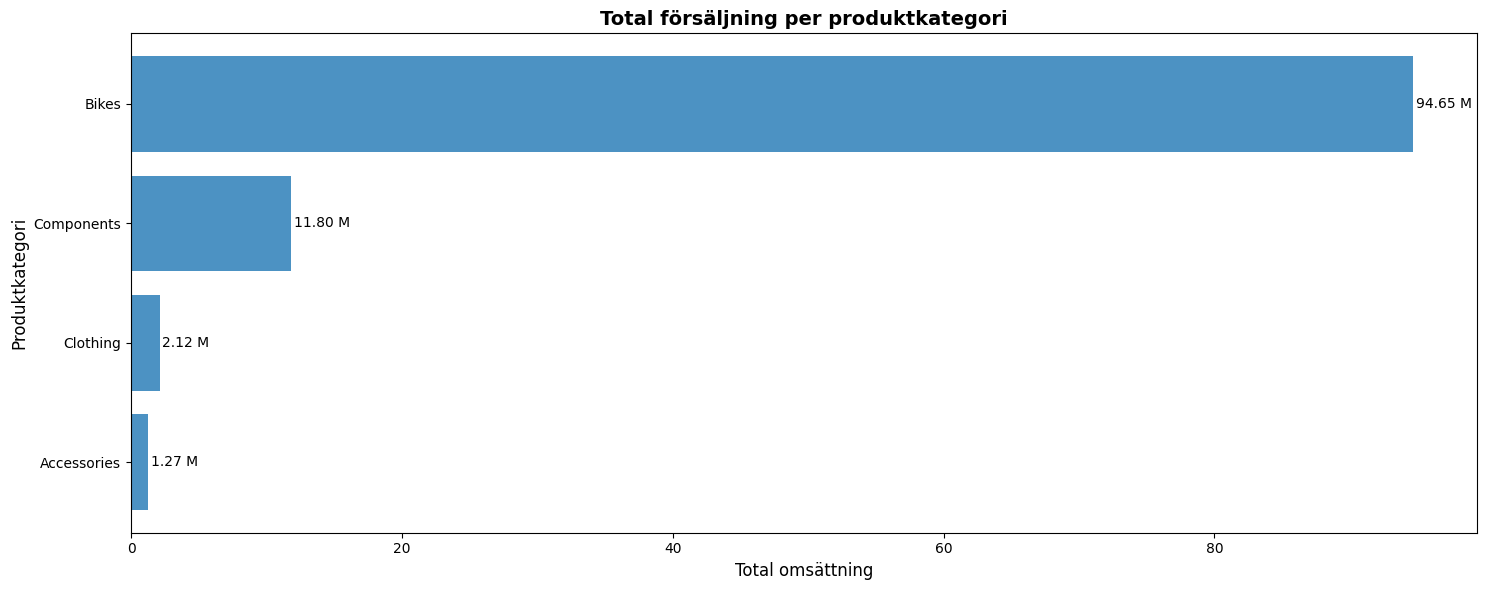

In [24]:
df_vis2 = df_vis2.sort_values('TotalOmsättning', ascending = False)
df_vis2 = df_vis2.iloc[::-1]                                            # störst överst

fig, ax = plt.subplots(figsize = (15, 6))

bars = ax.barh(
    df_vis2['CategoryName'],
    df_vis2['TotalOmsättning']/ 1_000_000,                               # i miljoner
    alpha = 0.8
)

for bar in bars:
    width = bar.get_width()
    ax.text(
        width + 0.2,
        bar.get_y() + bar.get_height()/ 2,
        f'{width:.2f} M',
        va = 'center'
    )

ax.set_xlabel('Total omsättning', fontsize = 12)
ax.set_ylabel('Produktkategori', fontsize = 12)
ax.set_title('Total försäljning per produktkategori', fontsize= 14, fontweight = 'bold')

plt.tight_layout()
plt.show()

### Insikter - Försäljning per produktkategori

Kategorin **Bikes** är den som genererar **högst omsättning** med ~ 94,7 miljoner, följt av Components ~ 11,8 miljoner.

Omsättningen är beräknad med hjälp av LineTotal, vilket inkluderar eventuella rabatter och därför ger en mer korrekt och rymlig bild av faktisk försäljning 

Kategori **Accessories** säljer **minst** med omsättning på ungefär 1,27 miljoner (största utvecklingsområde).


## Visualisering 3: Försäljning över tid
Hur har försäljningen utvecklats över tid?

Tabeller som används:
- Sales.SalesOrderHeader

Plan:
1. Aggregera per månad (minst 12 månader data) 
2. Få fram trenden - ökar försäljning, minskar den, är den säsongsberoende? Nämn högsta och lägsta månaden. Använda SUM, CAST samt DATEADD.
3. Skapa linjediagram
4. Analysera resultatet

In [52]:
query_vis3 = """
SELECT 
    FORMAT(OrderDate, 'yyyy-MM') AS YearMonth,
    CAST(SUM(TotalDue) AS decimal(18,2)) AS TotalSales
FROM Sales.SalesOrderHeader
WHERE 
    OrderDate >= (
        SELECT DATEADD(MONTH, -12, MAX(OrderDate))
        FROM Sales.SalesOrderHeader
    )
GROUP BY
    FORMAT(OrderDate, 'yyyy-MM')
ORDER BY
    YearMonth ASC;
"""

df_vis3 = query_df(query_vis3)

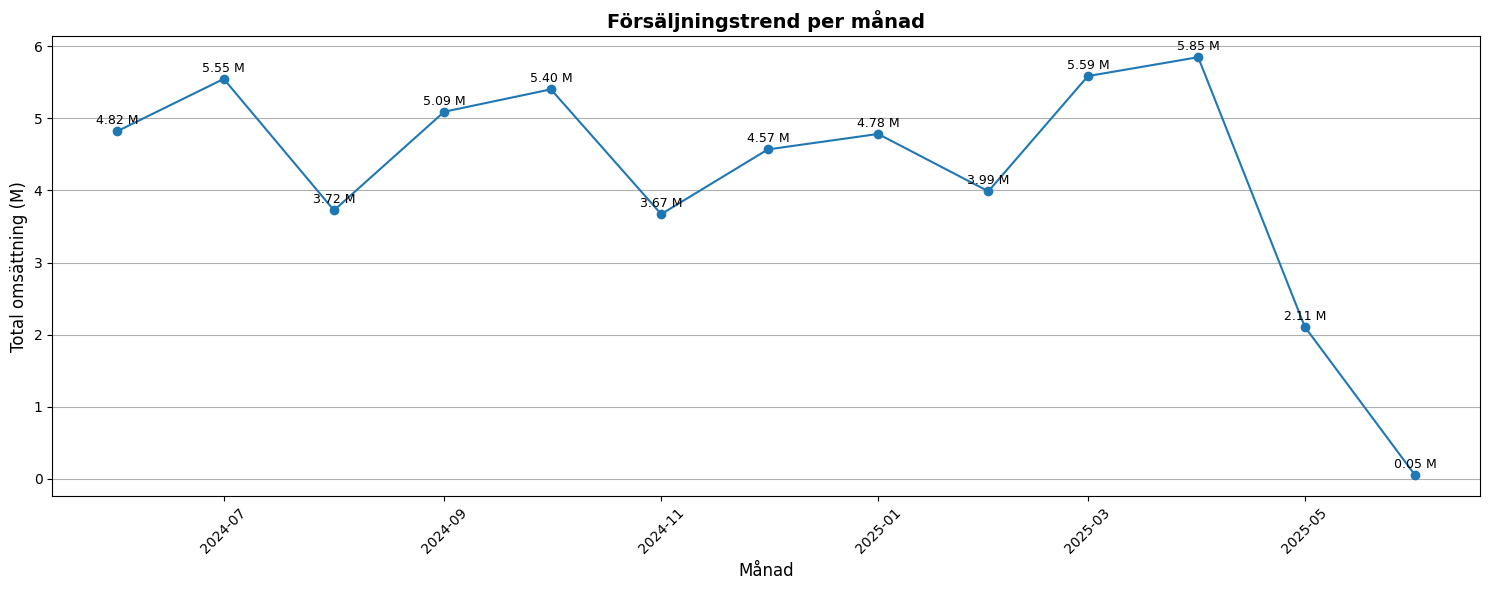

In [55]:
from matplotlib.ticker import FuncFormatter

df_vis3['YearMonth'] = pd.to_datetime(df_vis3['YearMonth'])
df_vis3['TotalSales'] = pd.to_numeric(df_vis3['TotalSales'], errors='coerce')
df_vis3 = df_vis3.dropna(subset=['TotalSales']).sort_values('YearMonth')

df_vis3['TotalSales_M'] = df_vis3['TotalSales'] / 1_000_000

fig, ax = plt.subplots(figsize = (15, 6))

ax.plot(df_vis3['YearMonth'], df_vis3['TotalSales_M'], marker="o", linestyle="-")

ax.set_title('Försäljningstrend per månad', fontsize= 14, fontweight= 'bold')
ax.set_xlabel('Månad', fontsize = 12)
ax.set_ylabel('Total omsättning (M)', fontsize = 12)
ax.grid(True, axis='y')
ax.ticklabel_format(style='plain', axis='y')

plt.xticks(rotation= 45)

for x, y in zip(df_vis3['YearMonth'], df_vis3['TotalSales_M']):
    ax.text(
        x,
        y + 0.1,
        f'{y:.2f} M',
        ha = 'center',
        fontsize = 9
    )

plt.tight_layout()
plt.show()

### Insikter- Försäljningstrend över tid

- Vissa månader uppvisar högre försäljning (toppar) vilket kan tyda på en säsongsvariation. 
- Den **högsta** försäljningen ser vi i **april 2025 (≈5.85 miljoner)**
- Den **lägsta** fullständiga månaden är **november 2024 (≈3.67 miljoner)**
- Den sista månaden i tidserien (2025-06) är ofullständigt och innehåller endast ett fåtal order, vilket förklarar den betydligt lägre försäljningssiffran jämfört med de övriga månaderna (den visar kraftig nedgång).

## Visualisering 4: Försäljning och antal ordrar per år
Hur ser total försäljning och antal ordrar ut per år?

Tabeller som används:
- Sales.SalesOrderHeader

Plan:
1. Visa både total försäljning och antal ordrar.
2. Jämföra åren - vilket år hade högst försäljning? Ökar både försäljning och antal ordrar, eller bara det ena? Använda YEAR, CAST och COUNT.
3. Skapa grupperat stapeldiagram.
4. Analysera resultatet

In [66]:
query_vis4 = """
SELECT 
    YEAR(OrderDate) AS OrderYear,
    CAST(SUM(TotalDue) AS decimal(18,2)) AS TotalSales,
    COUNT(SalesOrderID) AS AntalOrdar
FROM Sales.SalesOrderHeader
GROUP BY
    YEAR(OrderDate)
ORDER BY
    OrderYear ASC;
"""

df_vis4 = query_df(query_vis4)

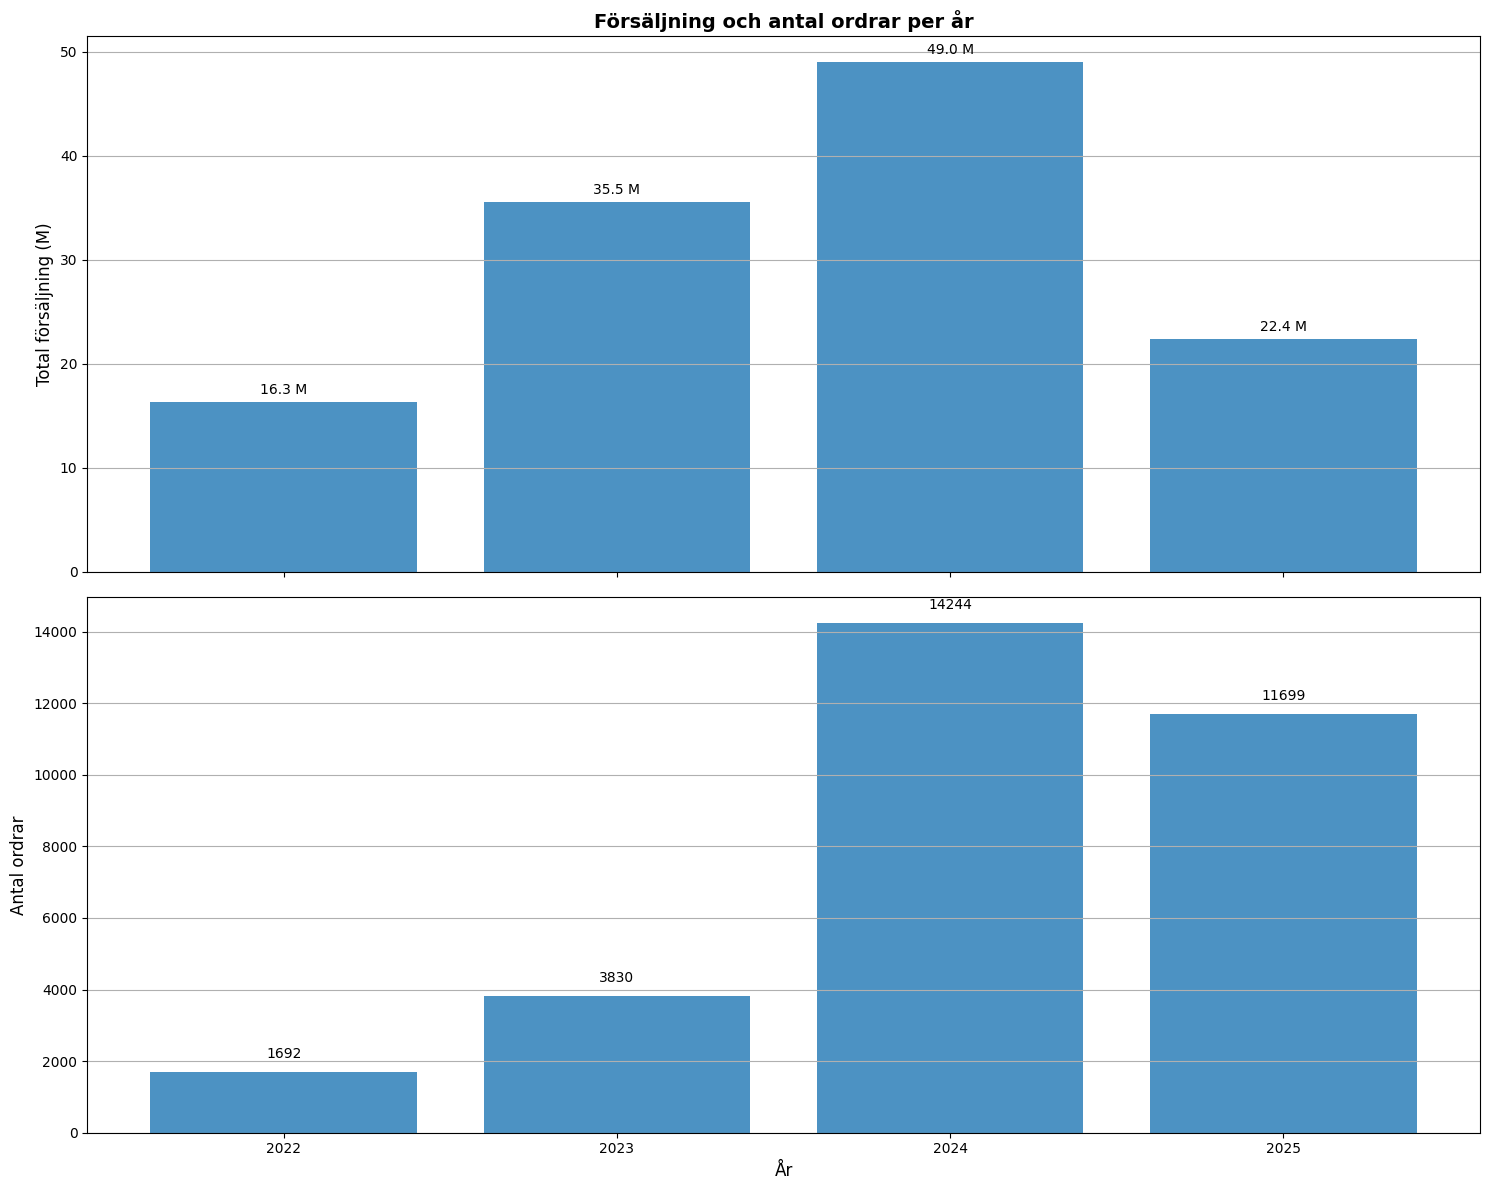

In [ ]:
take = df_vis4[['OrderYear', 'TotalSales', 'AntalOrdar']].dropna().copy().sort_values("OrderYear")
take['TotalSales_M'] = take['TotalSales'] / 1_000_000

fig, (ax1, ax2) = plt.subplots(2, 1, figsize= (15, 12), sharex = True)

bars_sales = ax1.bar(take['OrderYear'], take['TotalSales_M'], alpha = 0.8)
ax1.set_title('Försäljning och antal ordrar per år', fontsize= 14, fontweight= 'bold')
ax1.set_ylabel('Total försäljning (M)', fontsize = 12)
ax1.grid(True,axis="y")

for b in bars_sales:
    ax1.text(
        b.get_x() + b.get_width()/ 2,
        b.get_height() + 0.5,
        f'{b.get_height():.1f} M',
        ha = 'center',
        va = 'bottom',
        fontsize = 10
    )

bars_orders = ax2.bar(take['OrderYear'], take['AntalOrdar'], alpha = 0.8)
ax2.set_ylabel('Antal ordrar', fontsize= 12)
ax2.set_xlabel('År', fontsize = 12)
ax2.grid(True,axis="y")

for b in bars_orders:
    ax2.text(
        b.get_x() + b.get_width()/ 2,
        b.get_height() + 300,
        f'{int(b.get_height())}',
        ha = 'center',
        va = 'bottom',
        fontsize = 10
    )

ax2.set_xticks(take['OrderYear'])

plt.tight_layout()
plt.show()

### Insikter -  Försäljning och antal ordrar per år

- Total försäljning och antal ordrar ökar tydligt mellan 2022 och 2024. 
- År **2024** är det **starkaste året** med både högsta omsättning (cirka 49 miljoner) och flest antal ordrar (14 244). Man märker tillväxten i verksamheten.
- År **2025** visar **lägre totalförsäljning** (cirka 22,4 miljoner) trots ett relativt högt antal ordrar (11 699). Det kan finnas en förklaring i att året är **ofullständigt** och innehåller data fram till mitten av året (juni). 
- Sammanfattningsvis så ser man att försäljning och antal ordrar har ökat parallellt, men 2024 var en tydligt toppår.

## Visualisering 5: Top 10 produkter
Vilka 10 produkter genererar mest försäljning?

Tabeller som används:
- Production.Product
- Sales.SalesOrderDetail

Plan:
1. Visa både total försäljning och antal ordrar.
2. Nämna #1 produkten med exakt försäljningsvärde. Vilken kategori dominerar topp 10? Använda TOP och JOINa tabellerna.
3. Skapa horisontellt stapeldiagram.
4. Analysera resultatet.

In [ ]:
query_vis5 = """
SELECT TOP 10
    p.Name AS ProduktNamn,
    SUM(sod.LineTotal) AS Försäljningsvärde,
    SUM(sod.OrderQty) AS AntalSåldaProdukter
FROM Sales.SalesOrderDetail sod
JOIN Production.Product p ON sod.ProductID = p.ProductID
GROUP BY p.Name
ORDER BY Försäljningsvärde DESC;
"""

df_vis5 = query_df(query_vis5) 

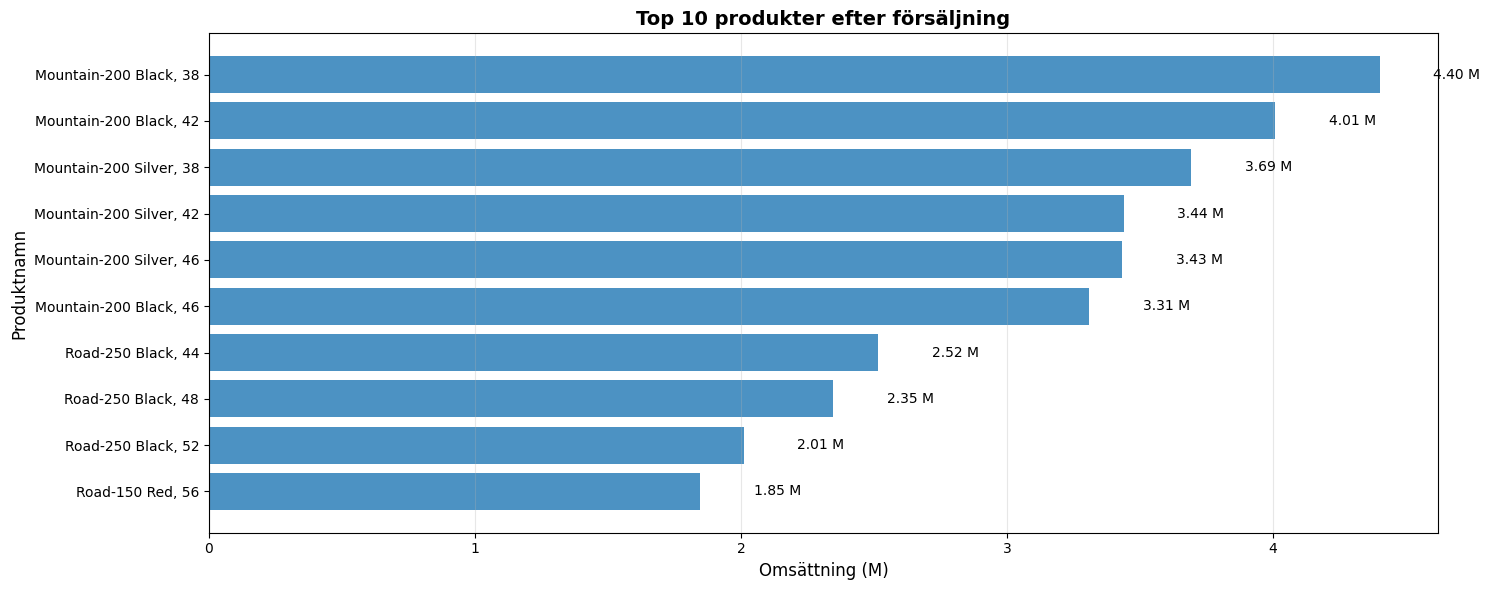

In [8]:
df_vis5 = df_vis5.sort_values('Försäljningsvärde', ascending = False)
df_vis5 = df_vis5.iloc[::-1]                                            # störst överst

fig, ax = plt.subplots(figsize = (15, 6))

bars = ax.barh(
    df_vis5['ProduktNamn'],
    df_vis5['Försäljningsvärde']/ 1_000_000,                               # i miljoner
    alpha = 0.8
)

for bar in bars:
    width = bar.get_width()
    ax.text(
        width + 0.2,
        bar.get_y() + bar.get_height()/ 2,
        f'{width:.2f} M',
        va = 'center'
    )

ax.set_xlabel('Omsättning (M)', fontsize = 12)
ax.set_ylabel('Produktnamn', fontsize = 12)
ax.set_title('Top 10 produkter efter försäljning', fontsize= 14, fontweight = 'bold')
ax.grid(True, axis = 'x', alpha = 0.3)
plt.tight_layout()
plt.show()

### Insikter - Top 10 produkter

- Analysen visar att **Mountain -200 Black, 38** är den produkten som, genererar högst försäljning med ett totalt försäljningsvärde på **4 400 592.80**
- **Topplistan domineras** tydligt av cykelprodukter, framförallt från **Mountain och Road segmenten**, vilket indikerar att **kategorin Bikes** står för den **största delen av försäljningen** bland de tio mest lönsamma produkterna. 
- Även om Kategoritabellen (Production.ProductCategory) inte används i SQL, kan man utifrån produktnamnen se att majoriteten av top-10 tillhör cyklarna. 

## Visualisering 6: Försäljning och antal kunder per region
Hur skiljer sig försäljningen mellan olika regioner, och hur många unika kunder har varje region?

Tabeller som används:
- Sales.SalesTerritory
- Sales.SalesOrderHeader
- Sales.Customer

Plan:
1. Visa total försäljning och antal unika kunder per region.
2. Hitta vilken region är starkast/svagast? Jämföra: Har regionen med högst försäljning också flest kunder, eller har de färre kunder med högre ordervärde? Vad betyder det? Använda COUNT DISTINCT för unika kunder och CAST SUM för total försäljning. 
3. Skapa en grupperat stapeldiagram (grouped bar) med två staplar per region (En stapel för försäljning, en stapel för antal kunder).
4. Analysera resultatet.

In [4]:
query_vis6 = """
SELECT 
    st.Name AS RegionName,
    COUNT(DISTINCT c.CustomerID) AS UniqueCustomers,
    CAST(SUM(soh.TotalDue) AS decimal(18,2)) AS TotalSales
FROM Sales.SalesOrderHeader soh
JOIN Sales.SalesTerritory st ON soh.TerritoryID = st.TerritoryID
JOIN Sales.Customer c ON soh.CustomerID = c.CustomerID
GROUP BY st.Name
ORDER BY TotalSales DESC;
"""

df_vis6 = query_df(query_vis6)

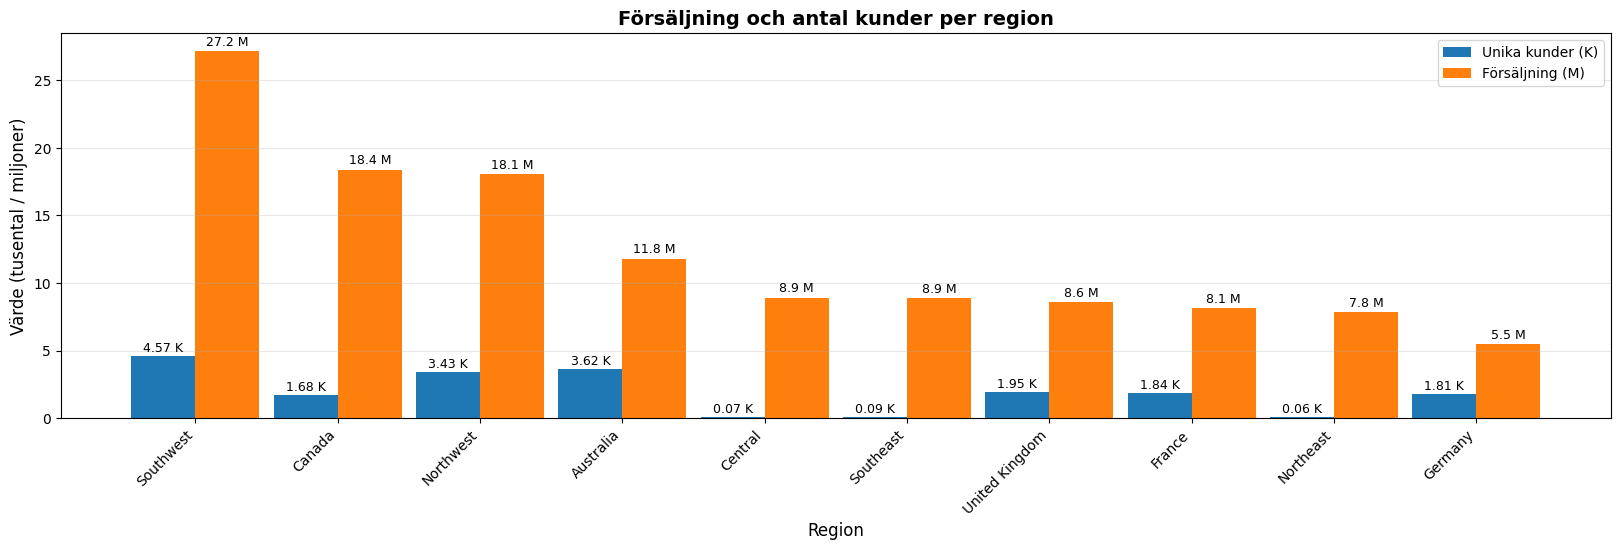

In [20]:
take = df_vis6[["RegionName", "UniqueCustomers", "TotalSales"]].dropna().copy()
take = take.sort_values("TotalSales", ascending = False)
take["TotalSales_M"] = take["TotalSales"] / 1_000_000
take["UniqueCustomers_K"] = take["UniqueCustomers"] / 1000

fig, ax = plt.subplots(figsize= (20, 5))

idx = np.arange(len(take)) 
width = 0.45

bars_cust = ax.bar(idx - width/2, take["UniqueCustomers_K"], width= width, label="Unika kunder (K)")
bars_sales = ax.bar(idx + width/2, take["TotalSales_M"], width= width, label= "Försäljning (M)")

ax.set_xticks(idx)
ax.set_xticklabels(take["RegionName"], rotation=45, ha="right")
ax.set_title("Försäljning och antal kunder per region", fontsize = 14, fontweight = "bold")
ax.set_xlabel("Region", fontsize = 12)
ax.set_ylabel("Värde (tusental / miljoner)", fontsize = 12)
ax.grid(True, axis="y", alpha = 0.3)
ax.legend()

for b in bars_cust:
    ax.text(b.get_x() + b.get_width()/2, b.get_height() + 0.1,
            f"{b.get_height():.2f} K", ha = "center", va = "bottom", fontsize = 9)
    
for b in bars_sales:
    ax.text(b.get_x() + b.get_width()/2, b.get_height() + 0.2,
            f"{b.get_height():.1f} M", ha = "center", va = "bottom", fontsize = 9)

plt.show()

### Insikter -  Försäljning och antal kunder per region

- **Regionen Southwest** är den **starkaste** regionen, när det handlar om **total försäljning (~27,2 M)** men har även **flest unika kunder (4565)**. Detta indikerar att den höga omsätttningen främst drivs av en stor kundbas.
- Regionen **Canada och Northwest** uppvisar **relativt hög försäljning (~18 M)** trots **färre kunder**. Det kan tyda på ett högre genomsnittligt ordervärde per kund. 
- De svagaste regionerna: **Northeast och Central**, har både **låg försäljning och få kunder** (50-90), vilket kan betyda mindre marknader snarare än låg köpkraft.
- Det är ingenting som ser 'orimligt högt' eller duplicerat ut, som betyder att Joins + COUNT DISTINCT fungerar korrekt. 

## Visualisering 7: Genomsnittligt ordervärde per region och kundtyp
Vilka regioner har högst/lägst genomsnittligt ordervärde, och skiljer det sig mellan individuella kunder och företagskunder?

Tabeller som används:
- Sales.SalesTerritory
- Sales.SalesOrderHeader
- Sales.Customer
- Sales.Store

Plan:
1. Visa total försäljning och antal ordrar per region.
2. Jämföra Store vs Individual - vilken grupp har högre ordervärde? Skiljer det sig mellan regioner? Vad kan förklara skillnaderna? Vilken region + kundtyp-kombination har högst ordervärde? 
3. Skapa en grupperat stapeldiagram (grouped bar) med två staplar per region (En stapel för Store, en stapel för Individual).
4. Analysera resultatet.

In [24]:
query_vis7 = """
;WITH SalesByRegionAndCustomerType AS (
    SELECT 
        st.Name AS RegionName,
        CASE
            WHEN c.StoreID IS NOT NULL THEN 'Store'
            WHEN c.PersonID IS NOT NULL THEN 'Individual'
            ELSE 'Unknow Customer Type'
    END AS CustomerType,
    COUNT(DISTINCT soh.SalesOrderID) AS NumberOfOrders,
    SUM(soh.TotalDue) AS TotalSales,
    SUM(TotalDue) / NULLIF(COUNT (DISTINCT soh.SalesOrderID), 0) AS AvgOrderValue

FROM Sales.SalesOrderHeader soh
JOIN Sales.SalesTerritory st ON soh.TerritoryID = st.TerritoryID
JOIN Sales.Customer c ON soh.CustomerID = c.CustomerID
LEFT JOIN Sales.Store s ON c.StoreID = s.BusinessEntityID

GROUP BY st.Name,
 CASE
        WHEN c.StoreID IS NOT NULL THEN 'Store'
        WHEN c.PersonID IS NOT NULL THEN 'Individual'
        ELSE 'Unknow Customer Type'
    END
),

RegionRank AS (
    SELECT
        RegionName,
        SUM(TotalSales) / NULLIF(SUM(NumberOfOrders), 0) AS AvgOrderValue_Total
    FROM SalesByRegionAndCustomerType  
    GROUP BY RegionName
)

SELECT
    srct.RegionName,
    srct.CustomerType,
    CAST(srct.TotalSales AS decimal(18,2)) AS TotalSales,
    srct.NumberOfOrders,
    CAST(srct.AvgOrderValue AS decimal(18,2)) AS AvgOrderValue

FROM SalesByRegionAndCustomerType srct  
JOIN RegionRank r ON srct.RegionName = r.RegionName

ORDER BY 
    r.AvgOrderValue_Total DESC,
    srct.CustomerType ASC;

"""

df_vis7 = query_df(query_vis7)

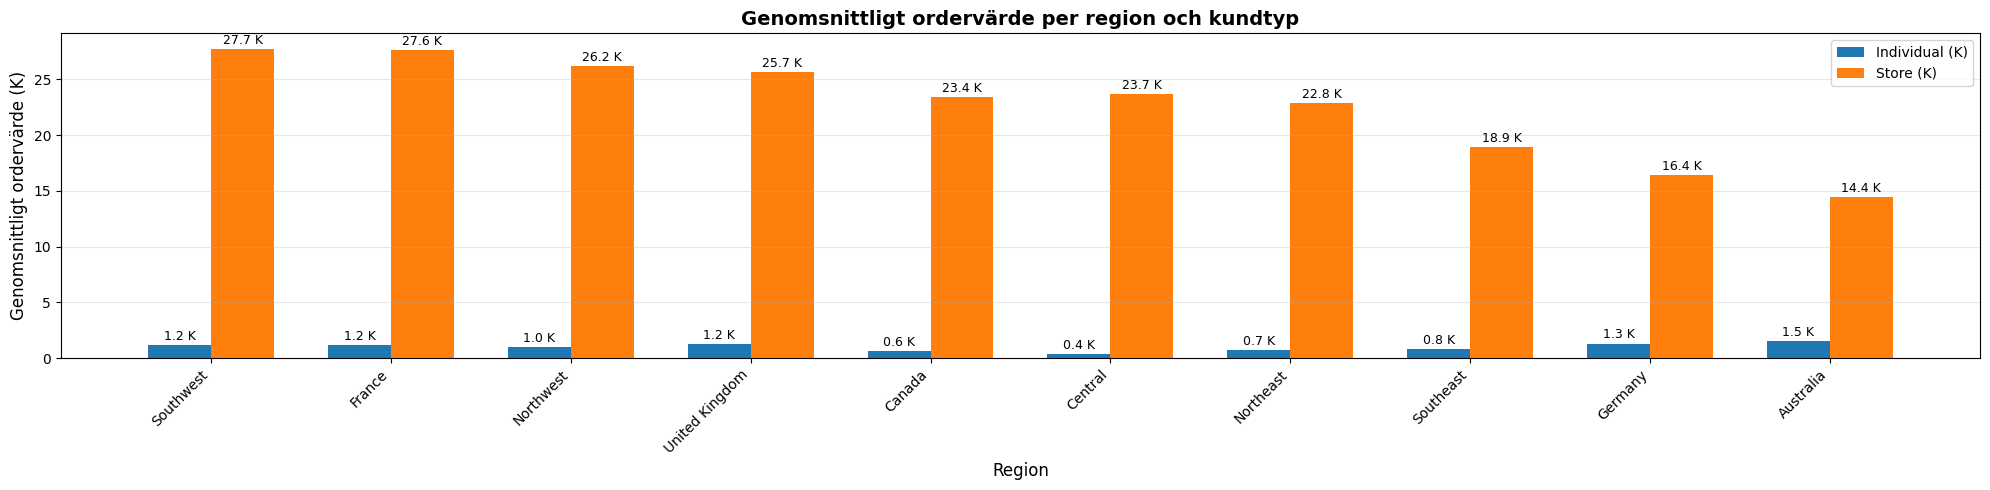

In [26]:
take = df_vis7[["RegionName", "CustomerType", "AvgOrderValue"]].dropna().copy()

pivot = take.pivot(index = "RegionName", columns = "CustomerType", values = "AvgOrderValue")
pivot = pivot.fillna(0)                                                                         # ifall någon region saknar typ
pivot["TotalAvg"] = pivot.sum(axis=1)
pivot = pivot.sort_values("TotalAvg", ascending = False)                                        # stora regioner efter högst genomsnitt (store + individual)
pivot = pivot.drop(columns = "TotalAvg")

pivot_k = pivot / 1000                                                                          # skala till k (tusen)

fig, ax = plt.subplots(figsize= (20, 5))
idx = np.arange(len(pivot_k))
width = 0.35

bars_ind = ax.bar(idx - width/2, pivot_k.get("Individual", 0), width= width, label="Individual (K)")
bars_store = ax.bar(idx + width/2, pivot_k.get("Store", 0), width= width, label= "Store (K)")

ax.set_xticks(idx)
ax.set_xticklabels(pivot_k.index, rotation=45, ha="right")
ax.set_title("Genomsnittligt ordervärde per region och kundtyp", fontsize = 14, fontweight = "bold")
ax.set_xlabel("Region", fontsize = 12)
ax.set_ylabel("Genomsnittligt ordervärde (K)", fontsize = 12)
ax.grid(True, axis="y", alpha = 0.3)
ax.legend()

# fixar siffror ovanpå staplar:
for bars in [bars_ind, bars_store]:
    for b in bars:
        h = b.get_height()
        ax.text(b.get_x() + b.get_width()/2, h + 0.2, f"{h:.1f} K", ha = "center", va = "bottom", fontsize = 9)
    
plt.tight_layout()
plt.show()

### Insikter - Genomsnittligt ordervärde per region och kundtyp

- Företagskunder (Store) har betydligt högre genomsnittligt ordervärde än individuella kunder (Inividual) i samtliga regioner. 
Det kan betyda att företagskunder gör färre men större inköp, medan privatpersoner handlar oftare men för mycket mindre pengar/ lägre ordervärde. 
- **Southwest - Store (≈27 739)** är den regionen + kundtypen som har absolut den **högsta genomsnittliga ordervärde**.
- Även regioner som **France och Central** uppvisar **höga genomsnittliga ordervärden** för Store-kunderna, trots att deras antal ordrar är relativt låg. I dessa regioner verkar företagskundsbasen vara mindre men mer köpstark.
- Individuella kunder har lägst snitt-ordervärde i samtliga regioner, men särskilt **låga värden ser vi i Canada och Central**. Som jag tidigare har nämnt, kan det indikera på att privatkunder står mer för volym än för högt ordervärde per köp.
- Skillnaderna mellan Store och Individual är **konsekventa** och tydliga över alla regioner. Det betyder definitivt att **kundtyp har större påverkan** på ordervärde än geografisk region. 


Sammanfattning : Privatkunder står för fler, men mindre köp, medan företagskunder driver högt ordervärde per order. 